In [22]:
# !pip3 install numpy pandas openpilot-tools

In [23]:
import numpy as np
import pandas as pd

import time
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import GridSearchCV, RepeatedKFold
from sklearn.model_selection import train_test_split

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import warnings
warnings.filterwarnings('ignore')

In [24]:
import random

random.seed(42)
np.random.seed(42)

In [25]:
1# Load your dataset
df = pd.read_csv('archive/'+'trajectories-0750am-0805am.csv')

# Rename for easier access
df = df.rename(columns={
    'Vehicle ID': 'veh_id',
    'Frame ID': 'frame_id',
    'Vehicle Velocity': 'v_ego',
    'Vehicle Acceleration': 'a_ego',
    'Preceding Vehicle': 'lead_id',
    'Spacing (Space Headway)': 'spacing',
    'Headway (Time Headway)': 'headway'
})

# -----------------------------
# 1. Unsafe Time Headway
# -----------------------------
df['unsafe_headway'] = df['headway'] < 1.0

# -----------------------------
# 2. Harsh Braking
# -----------------------------
df['harsh_braking'] = df['a_ego'] < -10 #ft/s #-3.05  # m/s²

# -----------------------------
# 3. Time to Collision (TTC)
# -----------------------------
# First, prepare a mapping of (frame_id, veh_id) -> v_ego to get V_lead
lead_speeds = df[['frame_id', 'veh_id', 'v_ego']].rename(columns={
    'veh_id': 'lead_id',
    'v_ego': 'v_lead'
})

# Merge lead vehicle speed into main dataframe
df = pd.merge(df, lead_speeds, how='left', on=['frame_id', 'lead_id'])

# Compute TTC only if V_ego > V_lead
df['relative_speed'] = df['v_ego'] - df['v_lead']
df['ttc'] = np.where(
    df['relative_speed'] > 0,
    df['spacing'] / df['relative_speed'],
    np.nan
)
df['critical_ttc'] = df['ttc'] < 3.0

# -----------------------------
# Summary
# -----------------------------
print("\n--- SAFETY METRICS SUMMARY ---")
print(f"Minimum headway: {df['headway'].min():.2f} s")
print(f"Unsafe headway events: {df['unsafe_headway'].sum()}")

print(f"Harsh braking events: {df['harsh_braking'].sum()}")

print(f"Minimum TTC: {df['ttc'].min():.2f} s")
print(f"Critical TTC events: {df['critical_ttc'].sum()}")

# -----------------------------
# Save output
# -----------------------------
df.to_csv('archive/'+"safety_metrics_vehicle_data_per_feet.csv", index=False)
print("Saved: safety_metrics_vehicle_data_per_feet.csv")


--- SAFETY METRICS SUMMARY ---
Minimum headway: 0.00 s
Unsafe headway events: 91570
Harsh braking events: 51237
Minimum TTC: 0.00 s
Critical TTC events: 2448
Saved: safety_metrics_vehicle_data_per_feet.csv


(1048576, 17)
<class 'numpy.ndarray'>
(1048576,)
<class 'pandas.core.series.Series'>


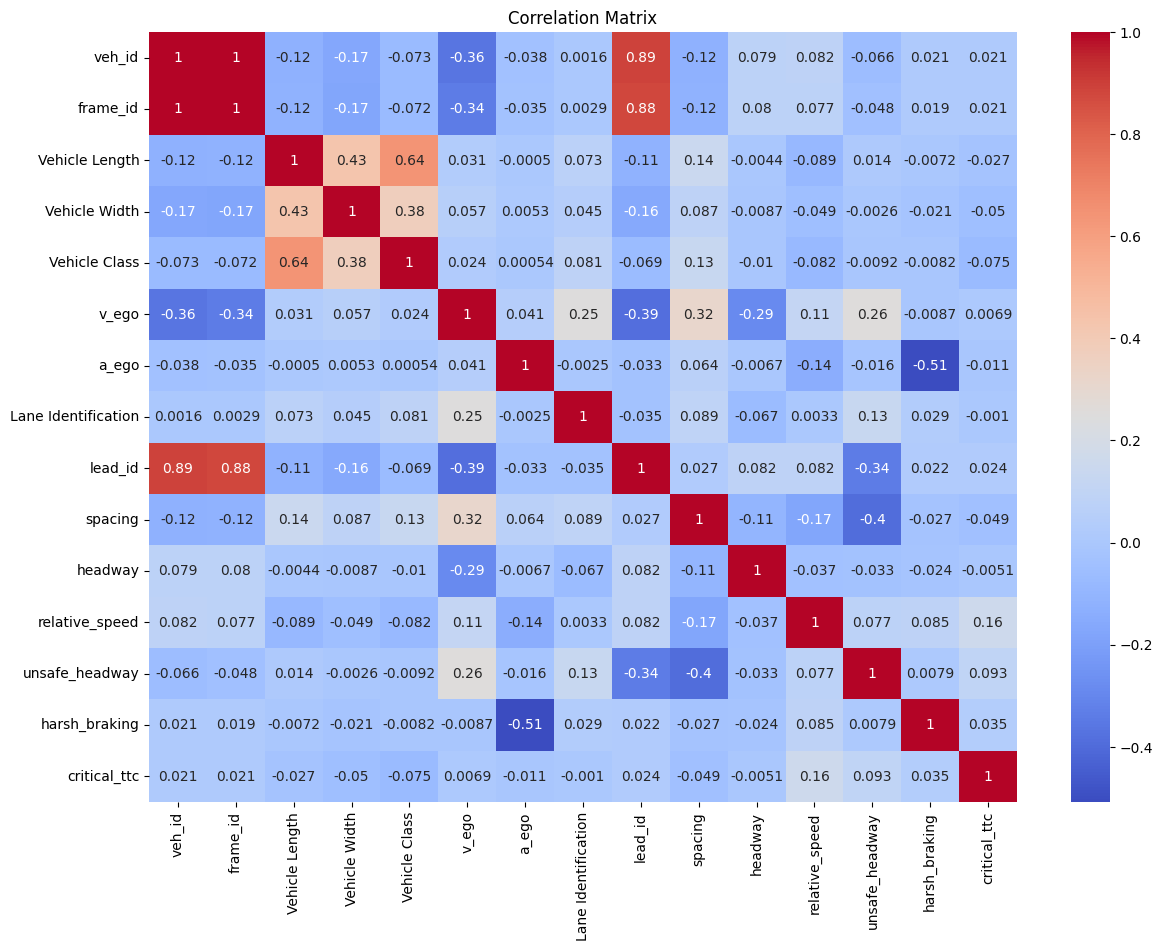

In [26]:
#start_time = time.monotonic()

# Data
#df = pd.read_csv('archive/'+"safety_metrics_vehicle_data_per_feet.csv")
X = df[['veh_id', 'frame_id','Global Time (Epoch Time)','Local X','Local Y','Global X','Global Y','Vehicle Length','Vehicle Width','Vehicle Class','v_ego','a_ego','Lane Identification',  'lead_id', 'spacing', 'headway','relative_speed']].to_numpy()
print(np.shape(X))
print(type(X))

Y = df['unsafe_headway'] #, 'unsafe_headway', 'relative_speed', 'ttc', 'critical_ttc'
init_Y_len = Y.shape[0]
print(np.shape(Y))
print(type(Y))


features = ['veh_id', 'frame_id',#'Global Time (Epoch Time)','Local X','Local Y','Global X','Global Y',
            'Vehicle Length','Vehicle Width','Vehicle Class',
            'v_ego','a_ego','Lane Identification', 'lead_id', 'spacing', 'headway', 'relative_speed']
# Combine X and Y into one DataFrame for correlation
df_plot = df[features + ['unsafe_headway'] + ['harsh_braking'] +  ['critical_ttc']].copy()
plt.figure(figsize=(14, 10))
sns.heatmap(df_plot.corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()


In [27]:
# Split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, shuffle = False) #  , random_state=42
X_train2, X_val, Y_train2, Y_val = train_test_split(X_train, Y_train, test_size=0.2, random_state=42)

In [28]:
'''model = HistGradientBoostingRegressor()
grid = dict()
grid['max_iter'] = [10, 20, 50, 100]
grid['learning_rate'] = [0.01, 0.1, 0.5, 1.0]
grid['max_bins'] = [15, 63, 127, 255]
grid['max_depth'] = [3, 7, 9]
# define the evaluation procedure
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
# define the grid search procedure
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv)
# execute the grid search
grid_result = grid_search.fit(X, Y)
# summarize the best score and configuration
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_)) # summarize all scores that were evaluated
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))'''

'model = HistGradientBoostingRegressor()\ngrid = dict()\ngrid[\'max_iter\'] = [10, 20, 50, 100]\ngrid[\'learning_rate\'] = [0.01, 0.1, 0.5, 1.0]\ngrid[\'max_bins\'] = [15, 63, 127, 255]\ngrid[\'max_depth\'] = [3, 7, 9]\n# define the evaluation procedure\ncv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)\n# define the grid search procedure\ngrid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv)\n# execute the grid search\ngrid_result = grid_search.fit(X, Y)\n# summarize the best score and configuration\nprint("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_)) # summarize all scores that were evaluated\nmeans = grid_result.cv_results_[\'mean_test_score\']\nstds = grid_result.cv_results_[\'std_test_score\']\nparams = grid_result.cv_results_[\'params\']\nfor mean, stdev, param in zip(means, stds, params):\n    print("%f (%f) with: %r" % (mean, stdev, param))'

In [29]:
# Train
hgbr_model = (HistGradientBoostingRegressor(max_depth=100)).fit(X_train, Y_train) #MultiOutputRegressor

In [30]:
# Predict
Y_predict_hgbr = hgbr_model.predict(X_test)
Y_predict_hgbr = np.where(Y_predict_hgbr<=0.5, 0, Y_predict_hgbr)
Y_predict_hgbr = np.where(Y_predict_hgbr>0.5, 1, Y_predict_hgbr)
# Find where both are 1
both_ones = (Y_test == 1) & (Y_predict_hgbr == 1)
predict_one_actual_zero = (Y_test == 0) & (Y_predict_hgbr == 1)
# Count how many times that happens
count = np.sum(predict_one_actual_zero)

print(f"Number of times prediction is 1 while actual is 0: {count}")

print(f"Number of times of unsafe headway in the actual data: {np.sum((Y_test == 1))}")
print(f"Number of times of unsafe headway in the predicted data: {np.sum((Y_predict_hgbr == 1))}")
print(np.sum((Y_test == 1))-np.sum((Y_predict_hgbr == 1)))

Number of times prediction is 1 while actual is 0: 0
Number of times of unsafe headway in the actual data: 12766
Number of times of unsafe headway in the predicted data: 12766
0


In [31]:
# Model validation

n_outputs = 1 #Y_val.shape[1]
n_iter = hgbr_model.n_iter_ #hgbr_model.estimators_[0].n_iter_  # Assumes all have same max_iter

# Initialize list to store average MAE per iteration
mae_hgbr_multi = []

# Iterate over each stage (boosting iteration)
for i in range(n_iter):
    preds = []

    # Collect predictions from each output estimator at iteration i
    # Collect predictions from each output estimator at iteration i
    #for est_idx in range(n_outputs):
    #    y_pred = list(hgbr_model.estimators_[est_idx].staged_predict(X_val))[i]
    #    preds.append(y_pred)
    y_pred = list(hgbr_model.staged_predict(X_val))[i]
    preds.append(y_pred)
    # Transpose to get predictions in shape (n_samples, n_outputs)
    Y_pred_stage = np.stack(preds, axis=1)

    # Compute MAE for this iteration
    mae = mean_absolute_error(Y_val, Y_pred_stage)
    mae_hgbr_multi.append(mae)

print(f"Total iterations: {len(mae_hgbr_multi)}")

Total iterations: 71


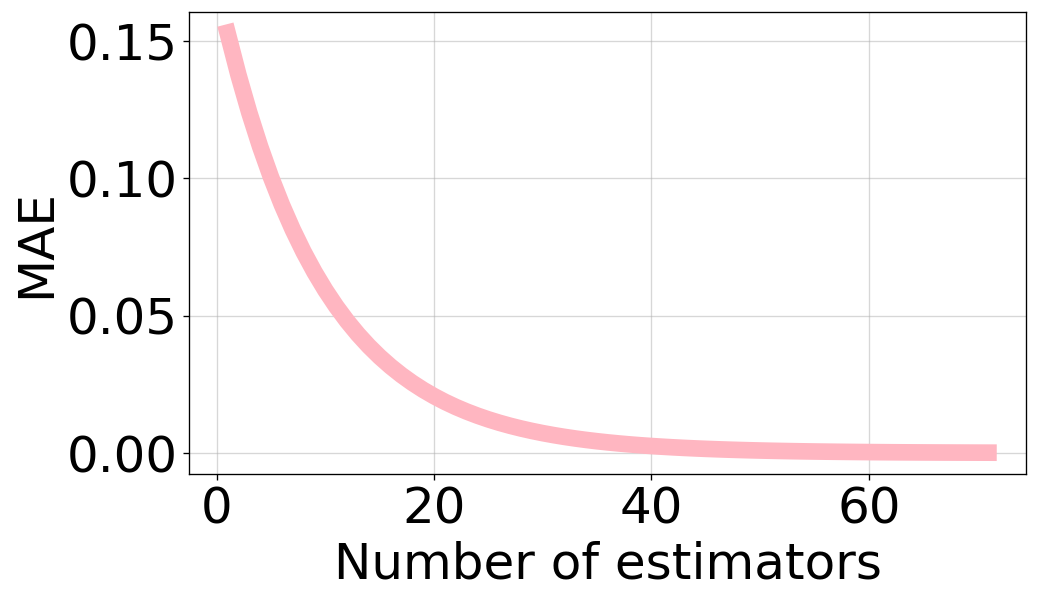

In [32]:
# Plot
fig, ax = plt.subplots(figsize=(9, 5), dpi=120)
plt.subplot().tick_params(labelsize=30)
ax.plot(np.arange(1,  len(mae_hgbr_multi) + 1), mae_hgbr_multi, color='lightpink', linewidth=10, label = "HGBR")
ax.set_xlabel('Number of estimators', fontsize=30)
ax.set_ylabel('MAE', fontsize=30)
ax.grid(True, alpha=0.5)
#plt.legend(bbox_to_anchor =(1,1),fontsize=20)
plt.savefig("hgbr_validation_unsafe_headway.pdf", format="pdf", bbox_inches="tight")

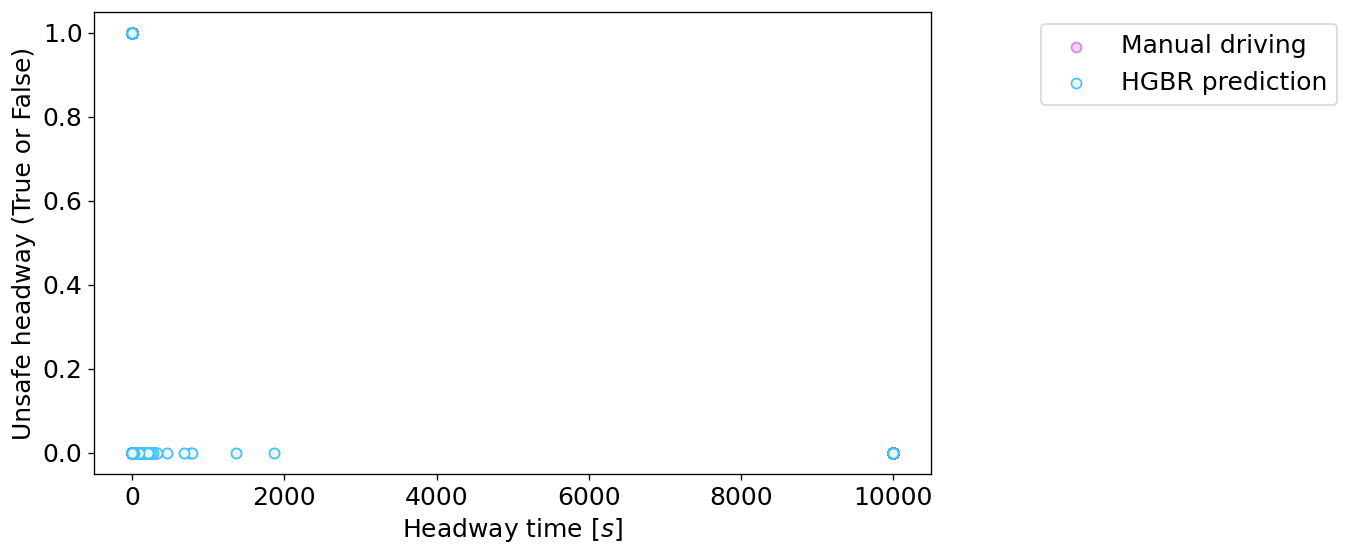

In [33]:
plt.figure(figsize=(9, 5), dpi=120)
plt.scatter(x=X_test[:,15], y=Y_test, color="#F3A0F2", marker="o",alpha=0.5, edgecolors="#9D2EC5", label='Manual driving')
plt.subplot().tick_params(labelsize=15)
plt.scatter(x=X_test[:,15], y=Y_predict_hgbr, color="#e9f8fe", edgecolors="#41c3fe", linewidth=1, label='HGBR prediction')
plt.xlabel('Headway time [$s$]', fontsize=15)
plt.ylabel('Unsafe headway (True or False)', fontsize=15)
plt.legend(bbox_to_anchor =(1.5,1),fontsize=15, ncol=1)
#plt.show()
plt.savefig("hgbr_prediction_unsafe_headway.png", format="png", bbox_inches="tight")

In [34]:
mae = mean_absolute_error(Y_test, Y_predict_hgbr)
mse = mean_squared_error(Y_test, Y_predict_hgbr)
rmse_ = mse ** 0.5
r_two = r2_score(Y_test, Y_predict_hgbr)
#mape = mean_absolute_percentage_error(Y_val, Y_predict_mlp)
#mae = mean_absolute_error(Y_val, Y_predict_mlp)
#mse = mean_squared_error(Y_val, Y_predict_mlp)
print(f"MAE : {mae}")
print(f"MSE : {mse}")
print(f"RMSE: {rmse_}")
print(f"R2  : {np.round(r_two,2)}")

MAE : 0.0
MSE : 0.0
RMSE: 0.0
R2  : 1.0


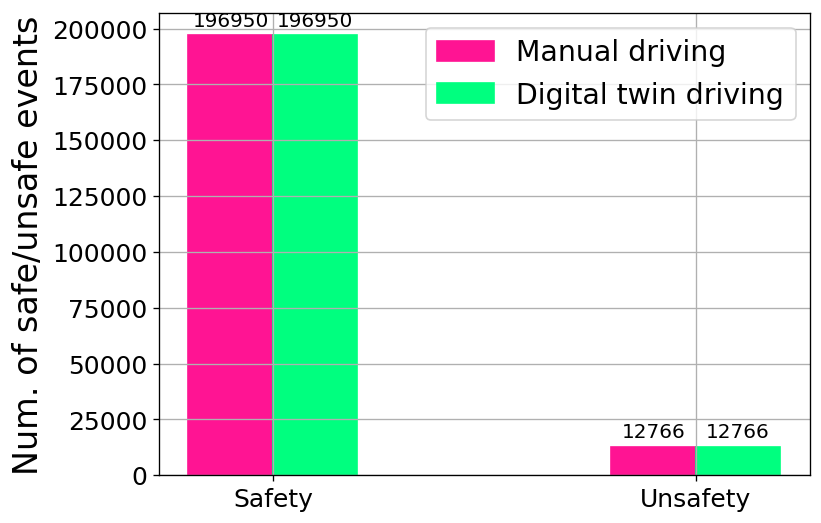

In [35]:
import matplotlib.pyplot as plt
import numpy as np

Y_test_one_or_zero = np.array([np.sum((Y_test == 0)),np.sum((Y_test == 1))])
Y_predict_hgbr_one_or_zero = np.array([np.sum((Y_predict_hgbr == 0)),np.sum((Y_predict_hgbr == 1))])

barWidth=0.2
ticks = range(len(Y_test_one_or_zero))
ticks1 = [x - barWidth/2 for x in ticks]
ticks2 = [x + barWidth/2 for x in ticks]
plt.figure(figsize=(7, 5), dpi=120)
bars1 = plt.bar(ticks1,Y_test_one_or_zero, color='deeppink', width=barWidth,edgecolor='deeppink', label="Manual driving")
bars2 = plt.bar(ticks2,Y_predict_hgbr_one_or_zero, color='springgreen', width=barWidth, edgecolor='springgreen', label="Digital twin driving")
plt.xlabel('', fontsize=20)
plt.ylabel('Num. of safe/unsafe events', fontsize=20)
xlabels = ["Safety","Unsafety"]
plt.bar_label(bars1, padding=3, fontsize=12)
plt.bar_label(bars2, padding=3, fontsize=12)
plt.xticks(ticks, xlabels, fontsize=15)
plt.yticks(fontsize=15)
plt.legend(loc="upper right", fontsize=17, ncol=1)#, markerscale=1, frameon=False
plt.grid()
plt.savefig("hgbr_headway.png", format="png", bbox_inches="tight")